In [127]:
import warnings
warnings.filterwarnings("ignore")

In [128]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, PredefinedSplit, RandomizedSearchCV
from scipy.stats import mode, pearsonr

In [129]:
np.random.seed(13)

## Question 1
Display the statistical values for each of the attributes, along with visualizations (e.g., histogram) of the distributions for each attribute. Are there any attributes that might require special treatment? If so, what special treatment might they require? 

### Pre-Processing Data


- retrieve labels from aggregate rock data 
- retireve second column for labels


Rock Types Categories are 1 for Igneous, 2 for metamorphic, and 3 for sedimentary 

In [130]:

labels = pd.read_excel("data/aggregateRockData.xlsx", header = None)[[1]][:480]
labels = labels.rename(columns={1: 'Rock_Types'})
labels.head()


,Rock_Types
0,1
1,1
2,1
3,1
4,1


- retrieve values from features, columns 3: 14

In [131]:
column_headers = [ "Token_number", "Angular_fragments", "Rounded _fragments",
                   "Straight_stripes", "Curved_stripes", "Physical_layers", "Veins", "Oily/shimmery_texture",
                   "Splotchy_texture", "Single_translucent_crystal", "Multiple_cubic_crystals", "Sandy_texture"]

features = pd.read_csv('data/feature_presence540.txt', delim_whitespace=True, header=None).iloc[:480, 2:14]
features.columns = column_headers
features.head()


,Token_number,Angular_fragments,Rounded _fragments,Straight_stripes,Curved_stripes,Physical_layers,Veins,Oily/shimmery_texture,Splotchy_texture,Single_translucent_crystal,Multiple_cubic_crystals,Sandy_texture
0,1,0.20,0.15,0.00,0.0,0.00,0.05,0.0,0.30,0.0,0.00,0.10
1,2,0.65,0.15,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.05,0.05
2,3,0.60,0.00,0.00,0.0,0.05,0.00,0.0,0.35,0.0,0.00,0.05
3,4,0.10,0.85,0.00,0.0,0.05,0.00,0.0,0.10,0.0,0.00,0.10
4,5,0.35,0.80,0.00,0.0,0.00,0.00,0.0,0.10,0.0,0.00,0.05


Merge rock labels onto features and adjust data types

In [132]:
DATA_DF = labels.merge(features, left_index=True, right_index=True)
DATA_DF

for col in DATA_DF.columns:
    # Convert to numeric if possible, otherwise keep the original type
    DATA_DF[col] = pd.to_numeric(DATA_DF[col], errors='ignore')
    
DATA_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Rock_Types                  480 non-null    int64  
 1   Token_number                480 non-null    int64  
 2   Angular_fragments           480 non-null    float64
 3   Rounded _fragments          480 non-null    float64
 4   Straight_stripes            480 non-null    float64
 5   Curved_stripes              480 non-null    float64
 6   Physical_layers             480 non-null    float64
 7   Veins                       480 non-null    float64
 8   Oily/shimmery_texture       480 non-null    float64
 9   Splotchy_texture            480 non-null    float64
 10  Single_translucent_crystal  480 non-null    float64
 11  Multiple_cubic_crystals     480 non-null    float64
 12  Sandy_texture               480 non-null    float64
dtypes: float64(11), int64(2)
memory usa

### Statistical Values

Basic Statistical Values

In [133]:
DATA_DF.describe()

,Rock_Types,Token_number,Angular_fragments,Rounded _fragments,Straight_stripes,Curved_stripes,Physical_layers,Veins,Oily/shimmery_texture,Splotchy_texture,Single_translucent_crystal,Multiple_cubic_crystals,Sandy_texture
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,2.000000,8.500000,0.084479,0.080208,0.067729,0.042292,0.165146,0.052396,0.144479,0.141458,0.031667,0.025104,0.119854
std,0.817348,4.614582,0.193996,0.197648,0.194792,0.160970,0.216635,0.102676,0.265689,0.168222,0.135647,0.112153,0.173149
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,4.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,8.500000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.100000,0.000000,0.000000,0.050000
75%,3.000000,12.250000,0.050000,0.050000,0.000000,0.000000,0.212500,0.050000,0.100000,0.200000,0.000000,0.000000,0.150000
max,3.000000,16.000000,1.000000,1.000000,1.000000,1.000000,0.950000,0.900000,1.000000,0.950000,1.000000,1.000000,1.000000


Check Null and Missing Values

In [134]:
DATA_DF.isnull().sum()

Rock_Types                    0
Token_number                  0
Angular_fragments             0
Rounded _fragments            0
Straight_stripes              0
Curved_stripes                0
Physical_layers               0
Veins                         0
Oily/shimmery_texture         0
Splotchy_texture              0
Single_translucent_crystal    0
Multiple_cubic_crystals       0
Sandy_texture                 0
dtype: int64

Plotting Histograms

In [135]:
COLORMAP = plt.cm.inferno

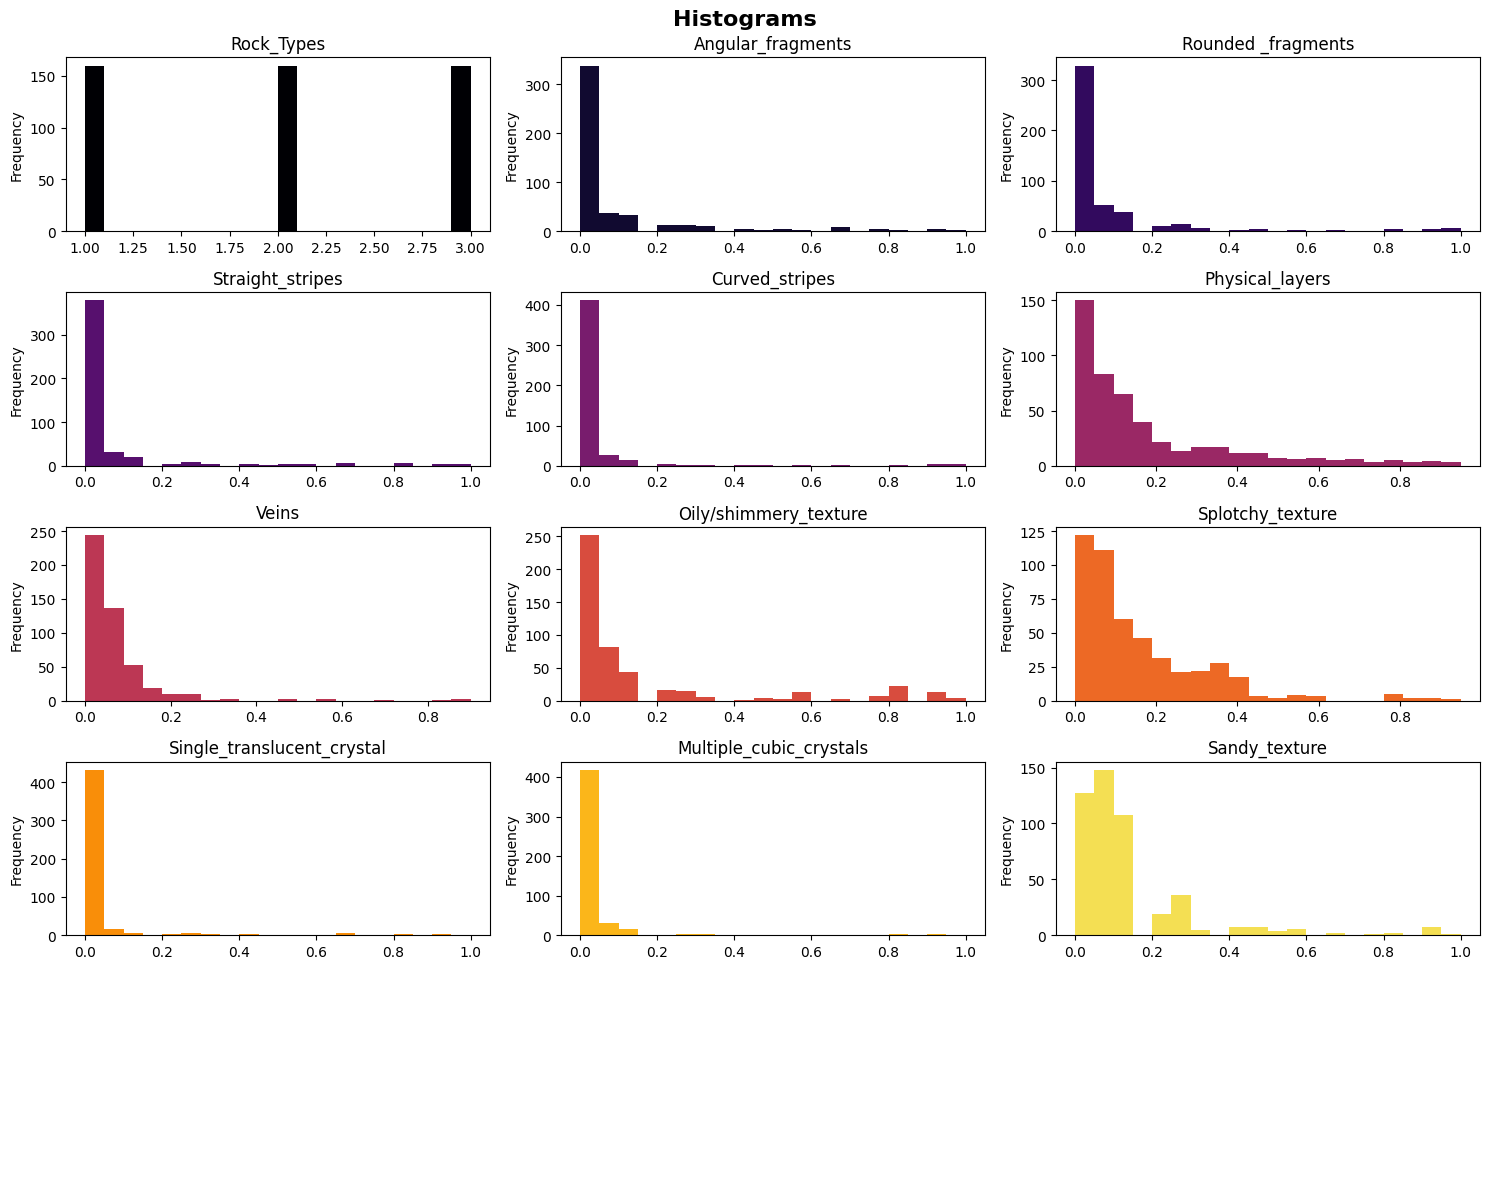

In [136]:
filtered_data = DATA_DF.drop(columns=['Token_number'])

fig, axes = plt.subplots(5, 3, figsize=(15, 12)) 
axes = axes.flatten()

for i, (col, ax) in enumerate(zip(filtered_data.columns, axes)):
    color = COLORMAP(i / len(filtered_data.columns))  
    filtered_data[col].plot.hist(ax=ax, color=color, bins=20, grid=False)
    ax.set_title(col)

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle('Histograms', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Plotting Box and Whiskers for features 

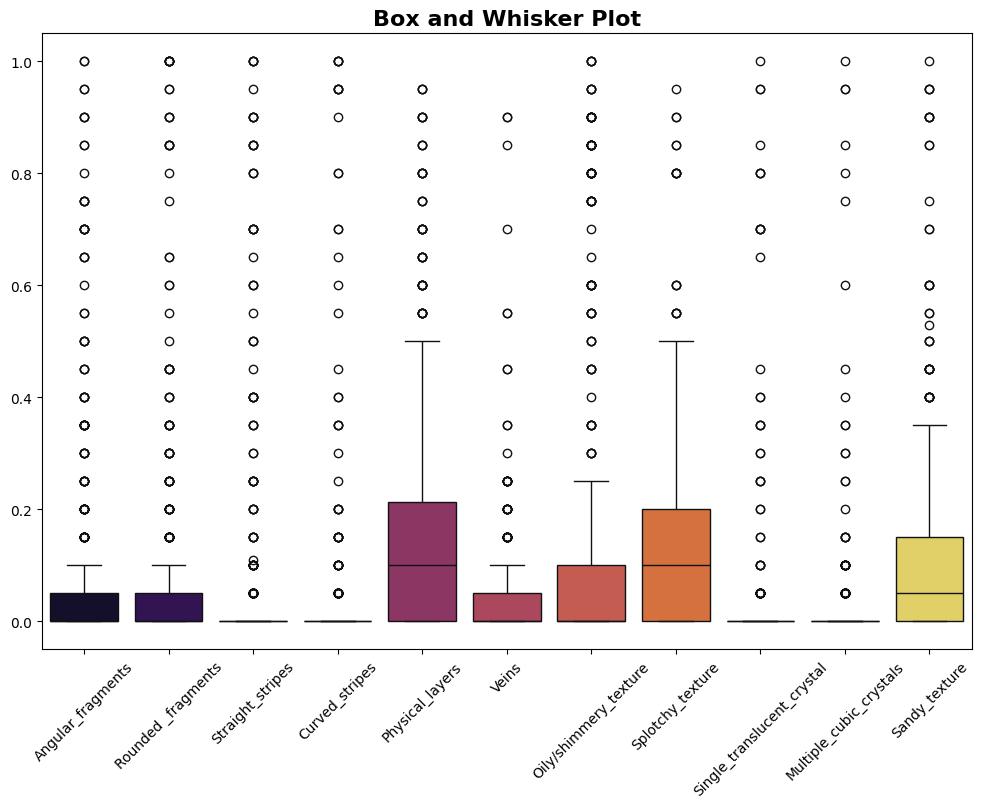

In [137]:
filtered_data = DATA_DF.drop(columns=['Rock_Types', 'Token_number'])

palette = sns.color_palette("inferno", n_colors=len(filtered_data.columns))

plt.figure(figsize=(12, 8))
sns.boxplot(data=filtered_data, palette=palette)
plt.xticks(rotation=45)  
plt.title("Box and Whisker Plot", fontsize=16, fontweight='bold')
plt.show()

### Answer

1. The stastical values of all the attributes have been studied along with the histogram and boxplots. Observations are:

    a. There are no Null values in the dataset.

    b. Data has lots of zeros which make the distribution right skewed for almost all the features.

    c. There are some outliers in the features as well.

    d. The target variable Rock Type has equal number of entries for each type.

    e. All features are ranged between 0 and 1.

    f. All the features are continuous and the target is categorical.

2. Treatments required by features:

    a. Standard scaling will be used to standardize the data before fitting a model.

    b. Outliers will not be treated as the data is very less.

# Question 2
Analyze and discuss the relationships between the data attributes and between the data attributes and labels. This involves computing the Pearson Correlation Coefficient (PCC) and generating scatter plots.


In [138]:

TARGET_VARIABLE = 'Rock_Types'
FEATURES = DATA_DF.columns.drop([TARGET_VARIABLE, 'Token_number'])

### Scatter Plots 

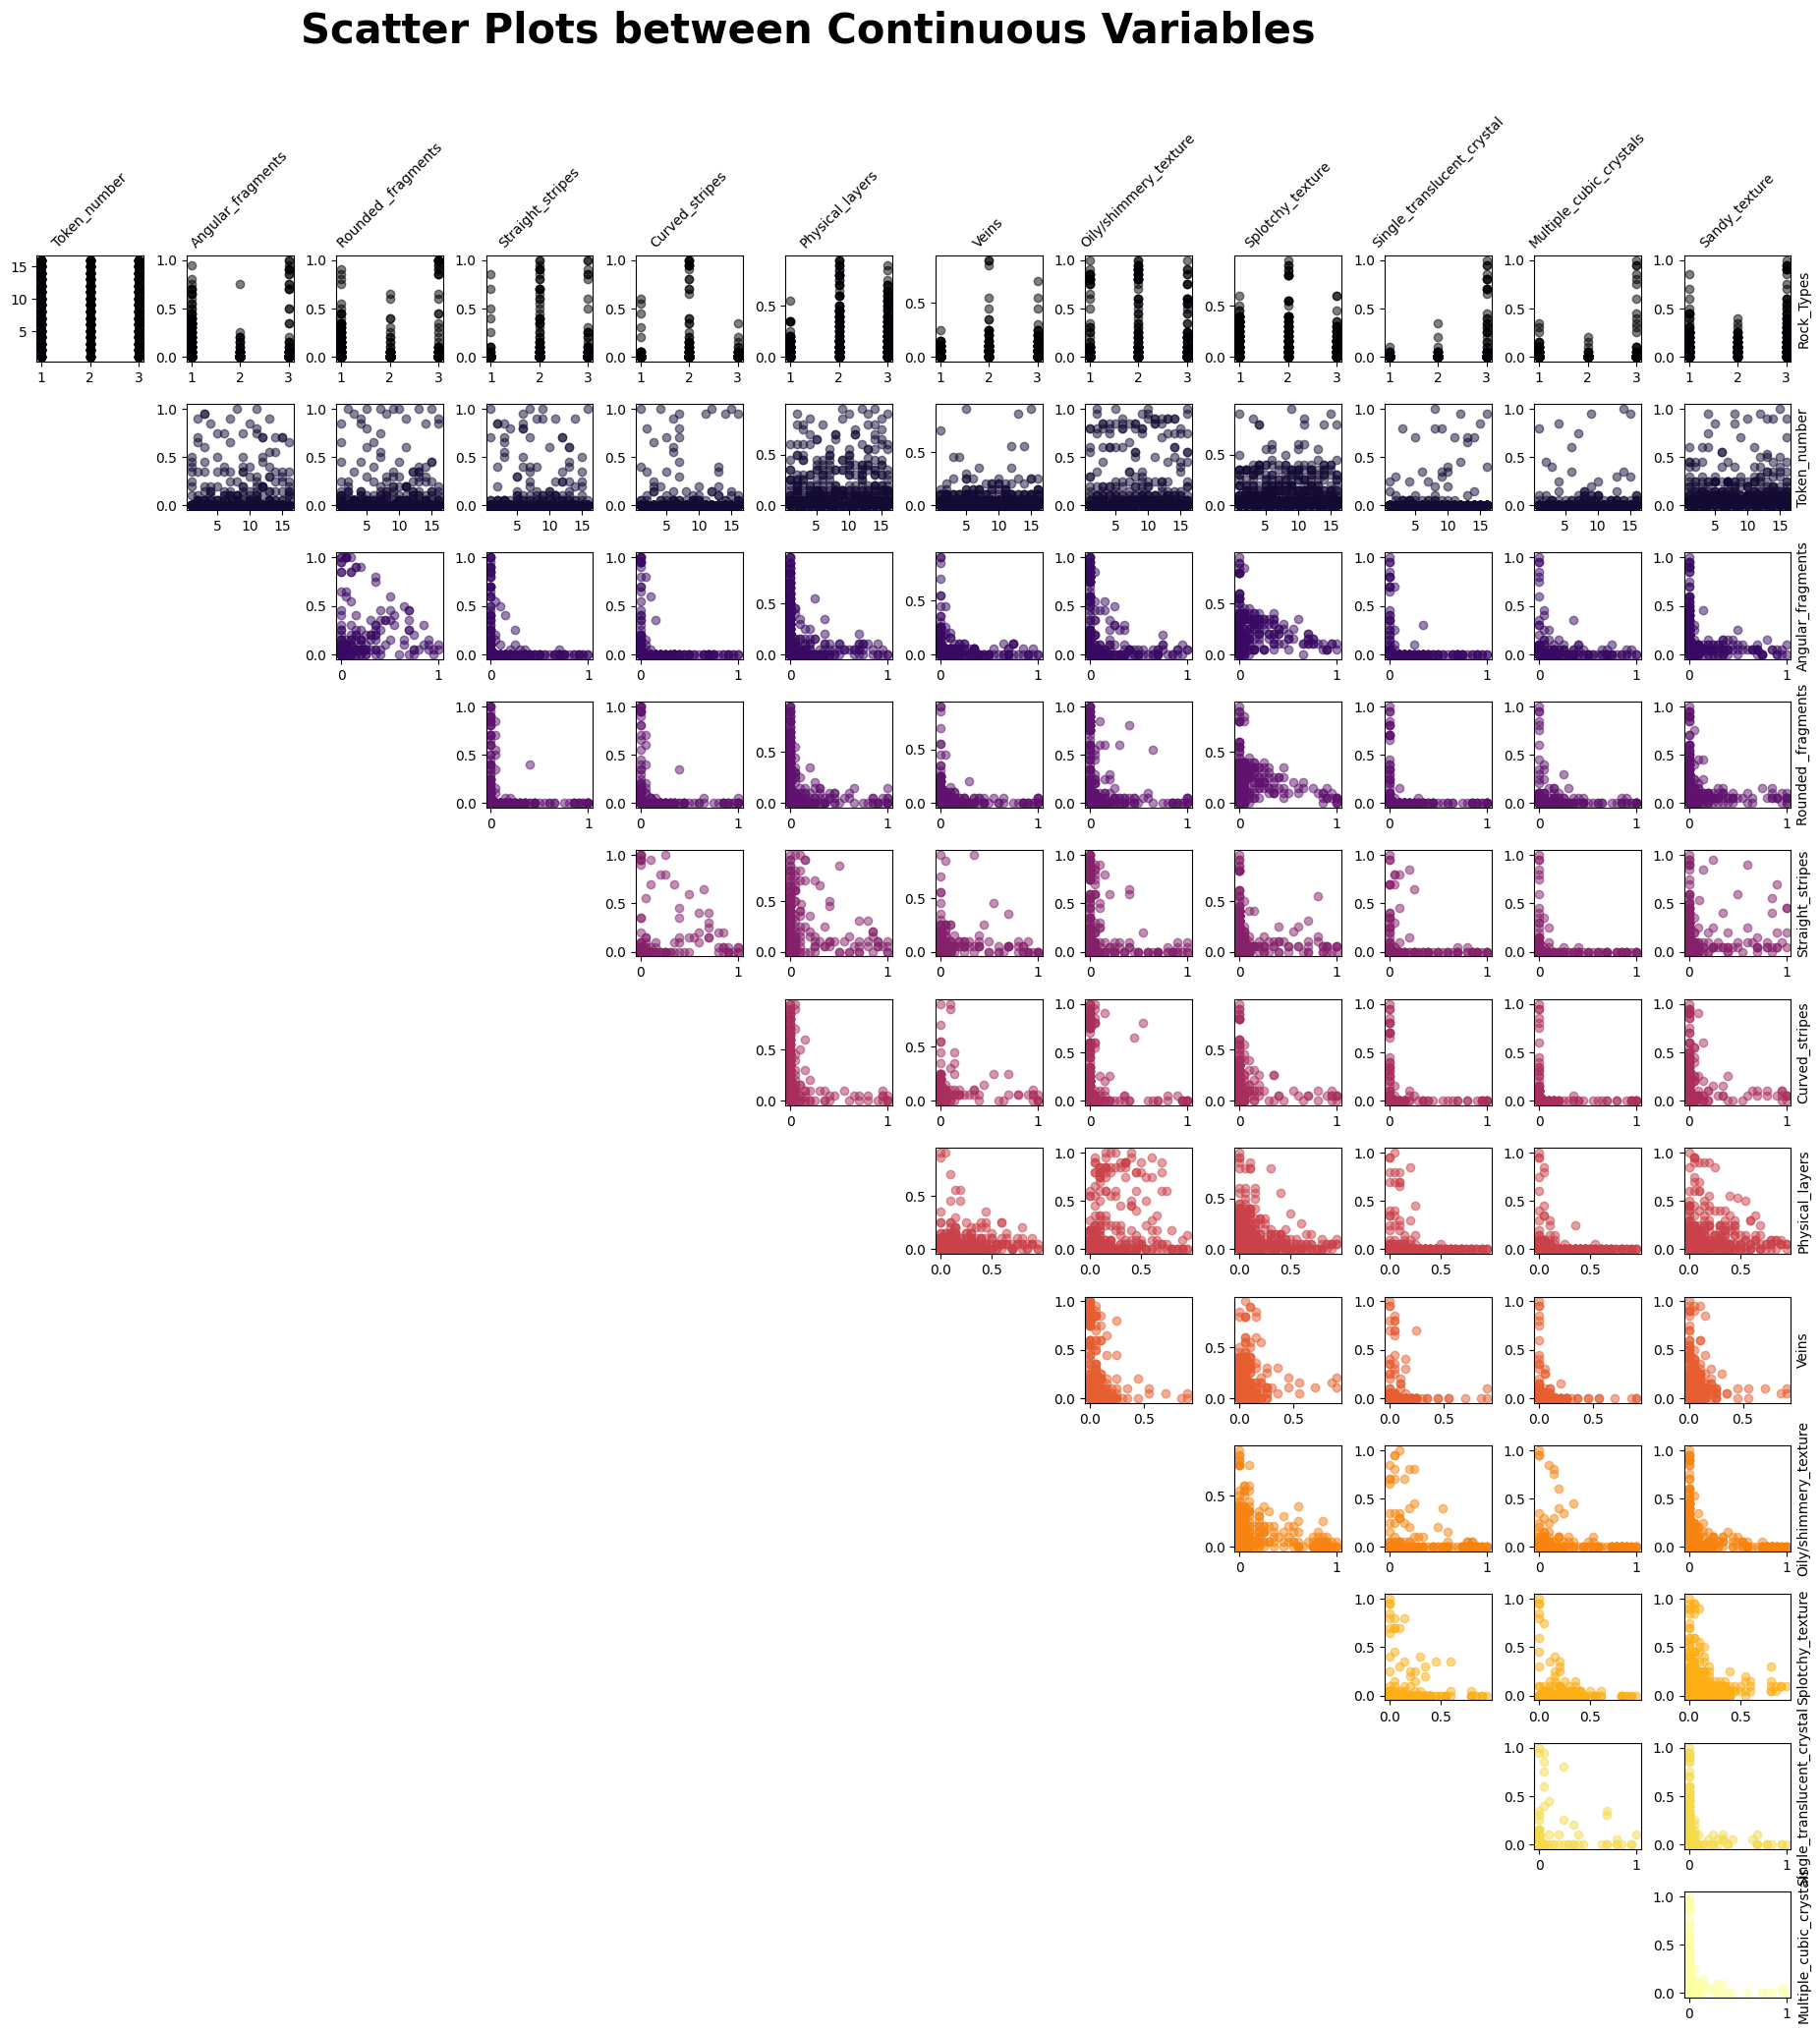

In [139]:

cols = DATA_DF.columns.tolist()
num_cols = len(cols)

# Set the size of the grid
fig, axes = plt.subplots(nrows=num_cols, ncols=num_cols, figsize=(25, 25))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(num_cols):
    for j in range(num_cols):
        # Only plot in the upper triangle (when column index j > i)
        if i < j: 
            color = COLORMAP(i / len(filtered_data.columns))  
            col1 = cols[i]
            col2 = cols[j]
            axes[i, j].scatter(DATA_DF[col1], DATA_DF[col2], alpha=0.5, color=color)
            
            # Set labels for the x and y axes
            if i == 0:
                axes[i, j].set_title(col2, fontsize=10, rotation=45)
            if j == num_cols - 1:
                axes[i, j].set_ylabel(col1, fontsize=10,)
                axes[i, j].yaxis.set_label_position("right")

        else:
            axes[i, j].set_visible(False) 


for i in range(num_cols):
    axes[num_cols-1, i].set_xlabel(cols[i], fontsize=10)


plt.suptitle('Scatter Plots between Continuous Variables', fontsize=30, fontweight='bold')
plt.show()

In [140]:

results = []
for i in FEATURES:
    stat, p_value = pearsonr(DATA_DF[i], DATA_DF[TARGET_VARIABLE])
    results.append({
        'Target': TARGET_VARIABLE,
        'Compared_Column': i,
        'Statistic': stat,
        'p_value': p_value

            
    })
stat = pd.DataFrame(results).sort_values(by='Statistic', key=abs, ascending=False)
print("Pearson Correlation of all features compared to target value Rock_Type")
stat

Pearson Correlation of all features compared to target value Rock_Type


,Target,Compared_Column,Statistic,p_value
4,Rock_Types,Physical_layers,0.266699,2.926048e-09
8,Rock_Types,Single_translucent_crystal,0.258910,8.608453e-09
7,Rock_Types,Splotchy_texture,-0.229273,3.818033e-07
5,Rock_Types,Veins,0.140553,2.024196e-03
10,Rock_Types,Sandy_texture,0.139845,2.133740e-03
0,Rock_Types,Angular_fragments,-0.122447,7.235725e-03
9,Rock_Types,Multiple_cubic_crystals,0.113872,1.254507e-02
2,Rock_Types,Straight_stripes,0.077495,8.989524e-02
3,Rock_Types,Curved_stripes,-0.017454,7.028771e-01
1,Rock_Types,Rounded _fragments,0.017446,7.030119e-01


### Pearson Correlation

Testing the pearson correlation of all feature values compared to the target column, sorting each value by the highest absolute error

### Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

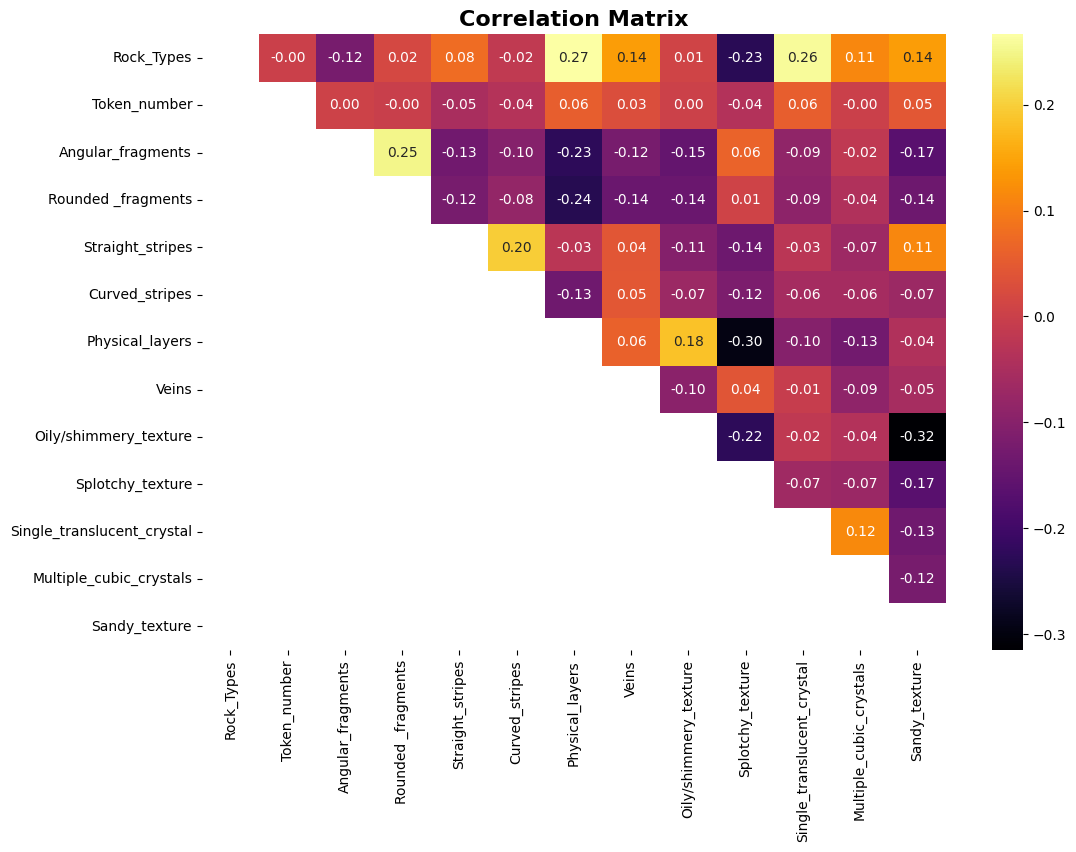

In [141]:
# PCC matrix for attributes and labels
correlation_matrix = DATA_DF.corr()
mask = np.tril(np.ones_like(correlation_matrix, dtype=bool))
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt=".2f", cmap=COLORMAP)
plt.title("Correlation Matrix", fontsize=16, fontweight='bold')

### Answer

1. Relationship between data attributes:

    a. From the scatter plots, there does not seem to be much correlation between the features, which means there is very low multi-collinearity amongst the attributes.

2. Relationship between the label and features:

    a. From the correlation matrix, some features seem to be positively and some are negatively correlated with the rock type.

    b. The top 2 most correlated features are Physical Layers and Single Translucent Crystal.

    c. Out of the 11 features, 7 have a p-value less than 0.05.

# Question 3
For training data, use token numbers 1-10, for validation 11 to 13, and for testing 14 to 16 (each of the 30 rock subtypes has 16 token numbers).

### Splitting

Scale Data 

In [142]:
scaler = StandardScaler()
# scaler = MinMaxScaler()
DATA_DF[FEATURES] = scaler.fit_transform(DATA_DF[FEATURES])

Split data into Train-Test-Validate sets

In [143]:
# Train Test Validate Split

train_tokens = [ x for x in range(1, 11)]
validate_tokens = [x for x in range(11, 14)]
test_tokens = [x for x in range(14, 17)]

train_data = DATA_DF[DATA_DF["Token_number"].isin(train_tokens)]
test_data = DATA_DF[DATA_DF["Token_number"].isin(test_tokens)]
validate_data = DATA_DF[DATA_DF["Token_number"].isin(validate_tokens)]

Splitting X and Y labels

In [144]:
X_train, y_train = train_data[FEATURES], train_data[TARGET_VARIABLE]
X_test, y_test = test_data[FEATURES], test_data[TARGET_VARIABLE]
X_validate, y_validate = validate_data[FEATURES], validate_data[TARGET_VARIABLE]

Checking the amount of data in each split

In [145]:
print("----------- Shape ------------")
print("training data: ", train_data.shape)
print("validate data: ", validate_data.shape)
print("test data: ", test_data.shape)

print("\n----------- Proportion ------------")
print(f"Training Data: {len(train_data)/ len(DATA_DF):.3f}%")
print(f"Validation Data: {len(validate_data)/ len(DATA_DF):.3f}%")
print(f"Testing Data: {len(test_data)/ len(DATA_DF):.3f}")

----------- Shape ------------
training data:  (300, 13)
validate data:  (90, 13)
test data:  (90, 13)

----------- Proportion ------------
Training Data: 0.625%
Validation Data: 0.188%
Testing Data: 0.188


### Check validity of splits

Ensure that each target class is represented in each split

In [146]:

print("Target distribution in training data: ")
print(train_data[TARGET_VARIABLE].value_counts())

print("Target distribution in test data: ")
print(test_data[TARGET_VARIABLE].value_counts())

print("Target validate in training data: ")
print(validate_data[TARGET_VARIABLE].value_counts())

Target distribution in training data: 
Rock_Types
1    100
2    100
3    100
Name: count, dtype: int64
Target distribution in test data: 
Rock_Types
1    30
2    30
3    30
Name: count, dtype: int64
Target validate in training data: 
Rock_Types
1    30
2    30
3    30
Name: count, dtype: int64


Checking the box and whisker plots for each column for each split 

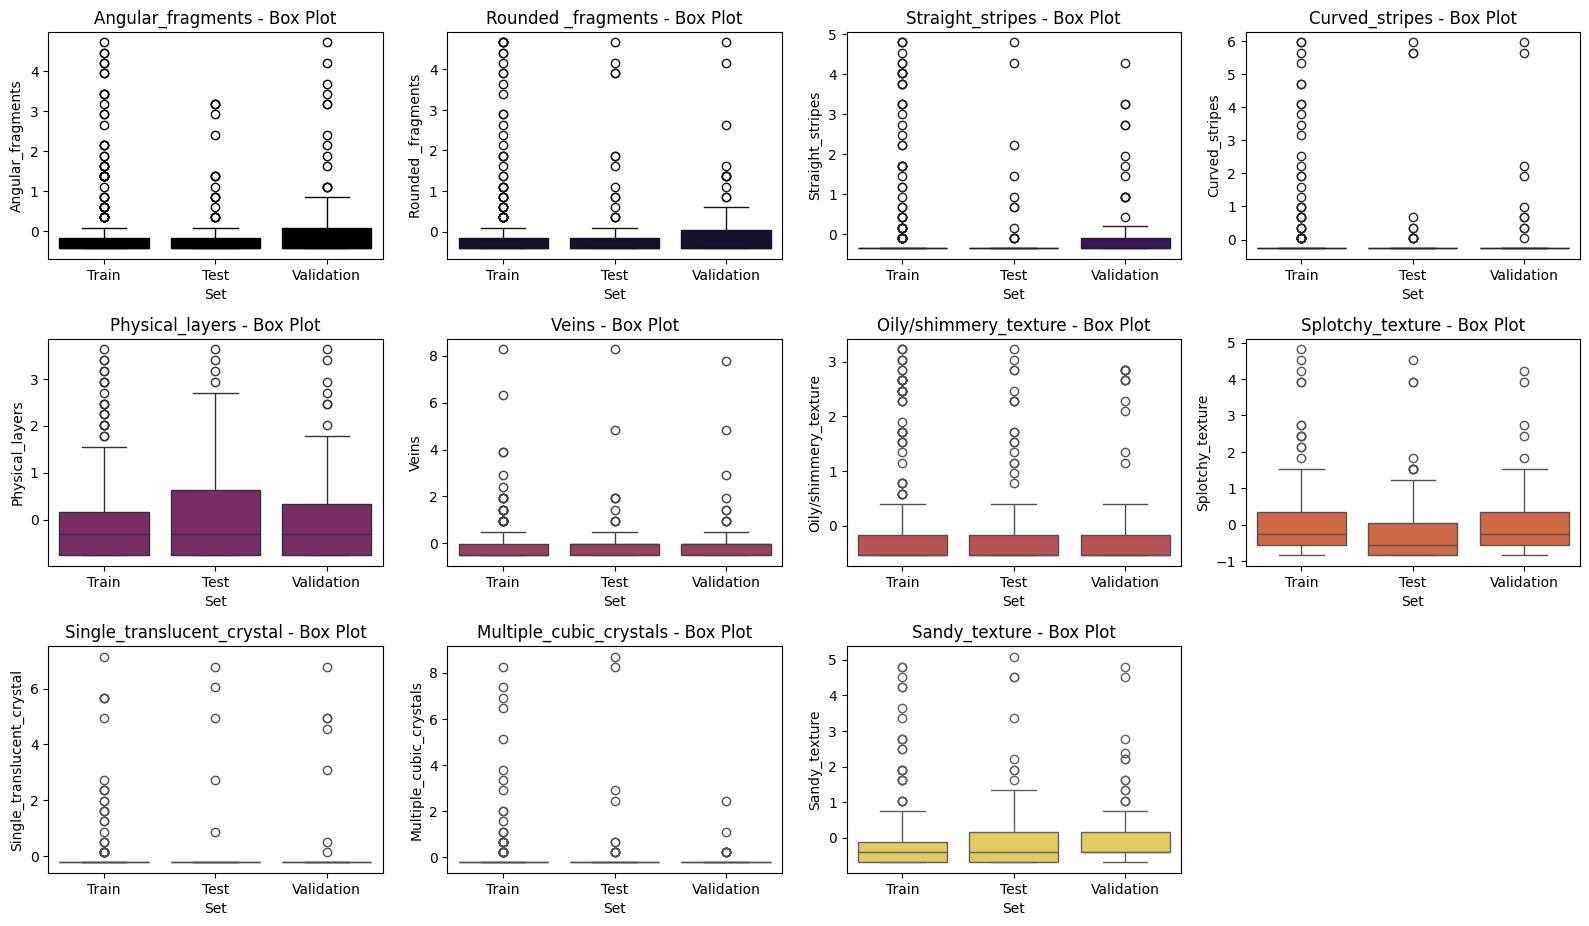

In [147]:
train_data["Set"] = "Train"
test_data["Set"] = "Test"
validate_data["Set"] = "Validation"
combined_data = pd.concat([train_data, test_data, validate_data])

# Drop 'Token_number' column if it's not needed
combined_data = combined_data.drop(columns=["Token_number", "Rock_Types"])

plt.figure(figsize=(16, 12))
for i, column in enumerate(combined_data.columns[:-1]):  
    plt.subplot(4, 4, i + 1)
    color = COLORMAP(i / len(filtered_data.columns))  
    sns.boxplot(x="Set", y=column, data=combined_data, color=color)
    plt.title(f"{column} - Box Plot")

plt.tight_layout()
plt.show()

Check the mean and std of each column for each split

In [148]:
summary_df = pd.DataFrame()

for column in DATA_DF.columns:
    if column != "Token_number":
        stats = {
            f"train_mean": train_data[column].mean(),
            f"train_std": train_data[column].std(),
            f"test_mean": test_data[column].mean(),
            f"test_std": test_data[column].std(),
            f"validate_mean": validate_data[column].mean(),
            f"validate_std": validate_data[column].std()
        }
        summary_df = pd.concat([summary_df, pd.DataFrame(stats, index=[column])])

summary_df.index.name = 'Column'
summary_df.reset_index(inplace=True)

summary_df

,Column,train_mean,train_std,test_mean,test_std,validate_mean,validate_std
0,Rock_Types,2.000000,0.817861,2.000000,0.821071,2.000000,0.821071
1,Angular_fragments,-0.025693,0.989579,-0.054647,0.866764,0.140291,1.151926
2,Rounded _fragments,0.003165,1.027976,-0.009496,1.024310,-0.001055,0.890938
3,Straight_stripes,0.031369,1.074117,-0.136791,0.806667,0.032226,0.918289
4,Curved_stripes,0.013733,0.986464,-0.021161,1.087949,-0.024616,0.968871
5,Physical_layers,-0.041492,0.952191,0.122550,1.112774,0.015756,1.042956
6,Veins,-0.033108,0.898548,0.052472,1.166730,0.057888,1.144407
7,Oily/shimmery_texture,0.004474,0.996713,0.008242,1.013430,-0.023156,1.013922
8,Splotchy_texture,0.019092,0.981341,-0.088021,1.070651,0.024382,1.000975
9,Single_translucent_crystal,-0.023369,0.878159,0.016399,1.158722,0.061498,1.205787


### Answer

1. The dataset has been split into Train, Validate and Test components using the criteria mentioned. The split in percentage is coming out to be 63/19/19 approximately.

2. The split has been verified using mean and standard deviation along with whisker plots to check if it is representative of the original data. The findings state that the split is indeed representative of the data with some minor expected noise.

# Question 4 
Train different classifiers and tweak the hyperparameters to improve performance (you can use the grid search if you want or manually try different values). Report training, validation and testing performance (classification accuracy, precision, recall and F1 score) and discuss the impact of the hyperparameters (use markdown cells in Jupyter Notebook to clearly indicate each solution):


Helpers for grid search

In [149]:
X_pre_defined = np.concatenate((X_train, X_validate), axis=0)
y_pre_defined = np.concatenate((y_train, y_validate), axis=0)

split_index = [-1] * len(X_train) + [0] * len(X_validate)
predefined_split = PredefinedSplit(test_fold = split_index)


def evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, model):
    # Fit the model on the training data
    model.fit(X=X_train, y=y_train)
    
    # Training predictions and metrics
    y_train_pred = model.predict(X_train)
    print("---------------------- Training Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_train, y_train_pred), 3))
    print("Precision: ", precision_score(y_train, y_train_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_train, y_train_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_train, y_train_pred, average="macro").round(3))
    
    # Testing predictions and metrics
    y_validate_pred = model.predict(X_validate)
    print("---------------------- Validation Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_validate, y_validate_pred), 3))
    print("Precision: ", precision_score(y_validate, y_validate_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_validate, y_validate_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_validate, y_validate_pred, average="macro").round(3))

    # Testing predictions and metrics
    y_test_pred = model.predict(X_test)
    print("---------------------- Testing Metrics ----------------------")
    print("Accuracy: ", round(accuracy_score(y_test, y_test_pred), 3))
    print("Precision: ", precision_score(y_test, y_test_pred, average="macro").round(3))
    print("Recall: ", recall_score(y_test, y_test_pred, average="macro").round(3))
    print("F1 Score: ", f1_score(y_test, y_test_pred, average="macro").round(3))


### Multinomial Logistic Regression (Softmax Regression)

In [150]:
# Modelling

logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 50)

# Evaluating on training data
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, logreg)


---------------------- Training Metrics ----------------------
Accuracy:  0.67
Precision:  0.671
Recall:  0.67
F1 Score:  0.67
---------------------- Validation Metrics ----------------------
Accuracy:  0.756
Precision:  0.762
Recall:  0.756
F1 Score:  0.751
---------------------- Testing Metrics ----------------------
Accuracy:  0.689
Precision:  0.697
Recall:  0.689
F1 Score:  0.688


#### Hyper Parameter Tuning using grid search

In [151]:

MODEL = LogisticRegression(fit_intercept=True, multi_class='multinomial')

# Define the base parameters and parameter grid
param_grid = {
    'solver': ['lbfgs', 'sag', 'saga', 'newton-cg'],
    'penalty': ['l1', 'l2', 'elsaticnet', 'none'],
    'C': [0.01, 0.1, 1, 10, 100],
    'max_iter': range(10,220,10)
}

grid_search = GridSearchCV(MODEL, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)

grid_search.fit(X_pre_defined, y_pre_defined)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Cross-Validated Accuracy:", best_score)

Fitting 1 folds for each of 1680 candidates, totalling 1680 fits
Best Parameters: {'C': 1, 'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}
Best Cross-Validated Accuracy: 0.7666666666666667


#### Hyperparameters selected for logistic regression:

Number of Iterations: 10

penalty = l2

C = 1

Solver = saga

#### Best Model Performance

In [152]:
best_logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 10, solver='saga', penalty='l2')

# Evaluating on training data
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_logreg)



---------------------- Training Metrics ----------------------
Accuracy:  0.67
Precision:  0.671
Recall:  0.67
F1 Score:  0.67
---------------------- Validation Metrics ----------------------
Accuracy:  0.756
Precision:  0.762
Recall:  0.756
F1 Score:  0.751
---------------------- Testing Metrics ----------------------
Accuracy:  0.689
Precision:  0.697
Recall:  0.689
F1 Score:  0.688


#### Observations

It’s evident that the grid search for optimal parameters improved the validation metrics; however, this enhancement did not translate into a significant improvement in the testing metrics.

### Support Vector Machines

In [153]:
svm_model = SVC()
# Evaluating on training data
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  0.737
Precision:  0.74
Recall:  0.737
F1 Score:  0.737
---------------------- Validation Metrics ----------------------
Accuracy:  0.767
Precision:  0.772
Recall:  0.767
F1 Score:  0.768
---------------------- Testing Metrics ----------------------
Accuracy:  0.678
Precision:  0.681
Recall:  0.678
F1 Score:  0.678


#### Hyper Parameter Tuning using grid search

In [154]:

MODEL = SVC()

param_grid = {
    'gamma': [round(x * 0.01, 3) for x in range(0, 101, 10)],
    'kernel': ["linear", "poly", "rbf"],
    'C': [0.01, 0.1, 1, 10, 100],
    'degree': range(1,5)
}

grid_search = GridSearchCV(MODEL, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)
grid_search.fit(X_pre_defined, y_pre_defined)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Fitting 1 folds for each of 660 candidates, totalling 660 fits
Best Parameters: {'C': 1, 'degree': 1, 'gamma': 0.3, 'kernel': 'rbf'}
Best Cross-Validated Accuracy: 0.8


#### Selected Hyper Parameters for SVM:


Kernel: RBF

C: 1

Degree: 1

Gamma: 0.3

#### Best Model Performance

In [155]:
best_svm_model = SVC(kernel='rbf', C=1, degree=1, gamma=.3)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_svm_model)

---------------------- Training Metrics ----------------------
Accuracy:  0.797
Precision:  0.798
Recall:  0.797
F1 Score:  0.797
---------------------- Validation Metrics ----------------------
Accuracy:  0.8
Precision:  0.8
Recall:  0.8
F1 Score:  0.799
---------------------- Testing Metrics ----------------------
Accuracy:  0.667
Precision:  0.668
Recall:  0.667
F1 Score:  0.667


### Observations

It’s evident that the grid search for optimal parameters improved the validation metrics; however, this enhancement actually led to a small reduction of all accuracy metrics in the testing set .

### Random Forest classifier

In [156]:
random_forest = RandomForestClassifier()
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, random_forest)


---------------------- Training Metrics ----------------------
Accuracy:  1.0
Precision:  1.0
Recall:  1.0
F1 Score:  1.0
---------------------- Validation Metrics ----------------------
Accuracy:  0.733
Precision:  0.731
Recall:  0.733
F1 Score:  0.729
---------------------- Testing Metrics ----------------------
Accuracy:  0.711
Precision:  0.716
Recall:  0.711
F1 Score:  0.712


#### Hyper Parameter Tuning using grid search

In [157]:

param_grid = {
    'n_estimators' : [10, 20, 50, 100, 150, 200],
    'max_depth' : [2, 4, 8, 16, 32],
    'min_samples_split' : [2, 5, 10, 20],
    'min_samples_leaf' : [2, 4, 8, 16, 32, 64]
}

rf = RandomForestClassifier(random_state = 10)

grid_search = GridSearchCV(rf, param_grid, cv = predefined_split, scoring = 'accuracy', verbose = 1)

grid_search.fit(X_pre_defined, y_pre_defined)

print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Fitting 1 folds for each of 720 candidates, totalling 720 fits
Best Parameters: {'max_depth': 16, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 20}
Best Cross-Validated Accuracy: 0.8


#### Best Parameters for Random Forest:

Max Depth: 16

Min Samples Leaf: 2

Min Samples Split: 10

Number of Estimators: 20

#### Best Model Parameter

In [158]:
best_random_forest = RandomForestClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=10, n_estimators=20)
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, best_random_forest)

---------------------- Training Metrics ----------------------
Accuracy:  0.867
Precision:  0.867
Recall:  0.867
F1 Score:  0.867
---------------------- Validation Metrics ----------------------
Accuracy:  0.778
Precision:  0.776
Recall:  0.778
F1 Score:  0.776
---------------------- Testing Metrics ----------------------
Accuracy:  0.678
Precision:  0.681
Recall:  0.678
F1 Score:  0.678


#### Feature Importance 

In [159]:
feature_imps = list(best_random_forest.feature_importances_)
fi_df = pd.DataFrame(columns = ["Feature", "Importance"])

for itr in range(len(X_train.columns)):
    curr_row = [X_train.columns[itr], feature_imps[itr]]
    fi_df.loc[len(fi_df)] = curr_row

In [160]:
fi_df.sort_values(by = ["Importance"], ascending = False)

,Feature,Importance
7,Splotchy_texture,0.141324
4,Physical_layers,0.131108
10,Sandy_texture,0.112038
0,Angular_fragments,0.108672
6,Oily/shimmery_texture,0.095717
2,Straight_stripes,0.084541
8,Single_translucent_crystal,0.083390
1,Rounded _fragments,0.076312
5,Veins,0.066740
3,Curved_stripes,0.059135


### Answer

1. 3 classifiers have been tried for the given dataset along with hyperparameter tuning for all of them. The best hyperparameters have been noted in the above markdown cells along with the train, test and validation metrics for each model.

2. Impact of hyperparameters:

    a. Logitic regression:

        i. C: out of the 5 values of C, 1 is picked. C value is inversely proportion to the regularization, hence the values 10 and 100 can lead to overfitting and therefore they are not selected.

        ii. Number of iterations: the best value is 10, which is the lowest in the parameter grid, signifying that the model converges within 10 iterations. Increasing the number of iterations does not improve the model.

        iii. Solver: the best one comes out to be saga, which is an adapted version of sag(stochastic average gradient).
    
    b. SVM:

        a. C: similar to logistic regression, the best value is 1. For SVM as well, increasing the C value leads to less regularization and hence more overfitting.

        b. Kernel: the best kernel is rbf. 

        c. Degree of Polynomial: for polynomial svm, linear is coming out to be the best. This could be a result of higher degree polynomials overfittiung.

        d. Gamma: the best gamma is 0.3. High value of gamma leads to a complex decision boundary which leads to overfitting. Decreasing the gamma means a smoother boundary.

    c. Random Forest:

        a. n_estimatores: the best estimators are 20. Increasing number of estimators can lead to a stable random forest but increase the overfitting.

        b. max_depth: the best depth is 16. Increasing the depth can lead to overfitting and a shallow tree can lead to underfitting.

        c. min_samples_split: the best value is 10. High value means the tree is not split unless there are enough samples, leading to simpler trees. Decreasing the value can lead to underfitting.

        d. min_samples_leaf: the best value is 2. Increasing the min sample leaf parameter makes the tree to have more samples to classify a leaf as a node. Low value can lead to overfitting. 

# Question 5
Combine your classifiers into an ensemble and try to outperform each individual classifier on the validation set. Once you have found a good one, try it on the test set. Describe and discuss your findings.

### Best Models

In [161]:
# Best logistic regression model
best_logreg = LogisticRegression(fit_intercept = True, multi_class = "multinomial", max_iter = 10, solver='saga', penalty='l2')

# Best SVM model
best_svm_model = SVC(kernel='rbf', C=1, degree=1, gamma=.3, probability=True)

# Best Random Forest model
best_random_forest = RandomForestClassifier(max_depth=16, min_samples_leaf=2, min_samples_split=10, n_estimators=20)


### Hard Voting Ensemble

In [162]:
models = [("lr", best_logreg), ("svm", best_svm_model), ("rf", best_random_forest)]

In [163]:
vc_hard = VotingClassifier(estimators = models, voting = 'hard')
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, vc_hard)

---------------------- Training Metrics ----------------------
Accuracy:  0.79
Precision:  0.791
Recall:  0.79
F1 Score:  0.79
---------------------- Validation Metrics ----------------------
Accuracy:  0.767
Precision:  0.767
Recall:  0.767
F1 Score:  0.765
---------------------- Testing Metrics ----------------------
Accuracy:  0.7
Precision:  0.7
Recall:  0.7
F1 Score:  0.698


### Soft Voting Ensemble

In [164]:
vc_soft = VotingClassifier(estimators = models, voting = 'soft')
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, vc_soft)

---------------------- Training Metrics ----------------------
Accuracy:  0.803
Precision:  0.805
Recall:  0.803
F1 Score:  0.804
---------------------- Validation Metrics ----------------------
Accuracy:  0.778
Precision:  0.777
Recall:  0.778
F1 Score:  0.776
---------------------- Testing Metrics ----------------------
Accuracy:  0.689
Precision:  0.688
Recall:  0.689
F1 Score:  0.687


### Comparisons of all models on the Test Set

In [165]:
model_eval = [("logistic_regression", best_logreg), ("Support_vector_Machine", best_svm_model), ("random_forest", best_random_forest), ('Ensemble_soft_voting', vc_soft), ('Ensemble_hard_voting', vc_hard) ]
cumulative_results = {name: {'Accuracy': 0, 'Precision': 0, 'Recall': 0, 'F1 Score': 0} for name, _ in model_eval}

n_runs = 100

# Run the evaluations multiple times
for _ in range(n_runs):
    for name, model in model_eval:
        # Train and predict
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # Update cumulative results
        cumulative_results[name]['Accuracy'] += accuracy_score(y_test, y_pred)
        cumulative_results[name]['Precision'] += precision_score(y_test, y_pred, average="macro")
        cumulative_results[name]['Recall'] += recall_score(y_test, y_pred, average="macro")
        cumulative_results[name]['F1 Score'] += f1_score(y_test, y_pred, average="macro")

# Calculate averages
average_results = []
for name, metrics in cumulative_results.items():
    average_results.append({
        'model': name,
        'Accuracy': metrics['Accuracy'] / n_runs,
        'Precision': metrics['Precision'] / n_runs,
        'Recall': metrics['Recall'] / n_runs,
        'F1 Score': metrics['F1 Score'] / n_runs
    })

# Convert to DataFrame and display
result = pd.DataFrame(average_results).sort_values(by=['Accuracy'], ascending=False)
result

,model,Accuracy,Precision,Recall,F1 Score
4,Ensemble_hard_voting,0.704444,0.706187,0.704444,0.704316
3,Ensemble_soft_voting,0.703000,0.705565,0.703000,0.702597
0,logistic_regression,0.694889,0.702225,0.694889,0.694575
2,random_forest,0.691222,0.693000,0.691222,0.690188
1,Support_vector_Machine,0.666667,0.667956,0.666667,0.666803


#### Answer

1. Both the ensembles are slightly outperforming the individual models.

2. Interestingly, hard voting outperforms soft voting, which is unexpected since the added weighting in soft voting generally introduces more nuance to the decision process. This outcome might be attributed to overfitting, as the additional complexity in soft voting could lead to reduced generalization on unseen data. 

# Question 6
Is your method better than a human?

In [166]:
human_preds = pd.read_csv("data/trialData.csv")

In [167]:
human_preds.shape

(88547, 12)

In [168]:
human_preds.head()

,subid,block,trial,rocknumber,category,subtype,token,type,catresponse,recresponse,cat_correct,rec_correct
0,A1HUMXQ7SEXD8E,1,1,331,Sedimentary,Bituminous Coal,11,NonparentTraining,Metamorphic,NaN,0,NaN
1,A1HUMXQ7SEXD8E,1,2,398,Sedimentary,Dolomite,14,NonparentTraining,Igneous,NaN,0,NaN
2,A1HUMXQ7SEXD8E,1,3,19,Igneous,Basalt,3,NonparentTraining,Sedimentary,NaN,0,NaN
3,A1HUMXQ7SEXD8E,1,4,338,Sedimentary,Breccia,2,NonparentTraining,Metamorphic,NaN,0,NaN
4,A1HUMXQ7SEXD8E,1,5,60,Igneous,Gabbro,12,NonparentTraining,Sedimentary,NaN,0,NaN


In [169]:
human_preds['block'].value_counts()

block
4    44274
3    14769
2    14755
1    14749
Name: count, dtype: int64

In [170]:
human_preds = human_preds[human_preds["rocknumber"].isin(list(range(1, 481)))]
human_preds.shape

(83627, 12)

In [171]:
train_human_preds = human_preds[human_preds["block"].isin([1, 2, 3])]
test_human_preds = human_preds[human_preds["block"].isin([4])]

In [172]:
train_human_preds.shape

(44273, 12)

In [173]:
test_human_preds.shape

(39354, 12)

In [174]:
print("---------------------- Train Accuracy Metrics ----------------------")
print(round(train_human_preds["cat_correct"].mean(), 3))

print("---------------------- Test Accuracy Metrics ----------------------")
print(round(test_human_preds["cat_correct"].mean(), 3))

---------------------- Train Accuracy Metrics ----------------------
0.56
---------------------- Test Accuracy Metrics ----------------------
0.598


### Mean and STD of human performance on each rocks

In [175]:

print("---------------------- Train Metrics ----------------------")
rock_stats = train_human_preds.groupby("rocknumber")["cat_correct"].agg(["mean", "std"]).rename(columns={"mean": "human_accuracy", "std": "human_std"})
train_stats = rock_stats.reset_index()


train_mean = train_stats["human_accuracy"].mean()
print(f"Training Mean Accuracy of all rocks: {train_mean}")
train_stats


---------------------- Train Metrics ----------------------
Training Mean Accuracy of all rocks: 0.5599275656175603


,rocknumber,human_accuracy,human_std
0,1,0.764228,0.425346
1,9,0.642276,0.480307
2,11,0.430894,0.496211
3,12,0.772358,0.420165
4,14,0.726531,0.446652
...,...,...,...
175,466,0.321138,0.467866
176,469,0.552846,0.498213
177,473,0.422764,0.495006
178,474,0.386179,0.487865


In [176]:
print("---------------------- Test Metrics ----------------------")
rock_stats = test_human_preds.groupby("rocknumber")["cat_correct"].agg(["mean", "std"]).rename(columns={"mean": "human_accuracy", "std": "human_std"})
test_stats = rock_stats.reset_index()

test_mean = test_stats["human_accuracy"].mean()
print(f"Testing Mean Accuracy of all rocks: {test_mean}")
test_stats

---------------------- Test Metrics ----------------------
Testing Mean Accuracy of all rocks: 0.5984089776752296


,rocknumber,human_accuracy,human_std
0,1,0.695122,0.463189
1,2,0.719512,0.452002
2,3,0.451220,0.500677
3,4,0.500000,0.503077
4,5,0.512195,0.502927
...,...,...,...
475,476,0.609756,0.490807
476,477,0.524390,0.502478
477,478,0.426829,0.497661
478,479,0.365854,0.484633


In [177]:
evaluate_model(X_train, y_train, X_validate, y_validate, X_test, y_test, vc_hard)

---------------------- Training Metrics ----------------------
Accuracy:  0.79
Precision:  0.792
Recall:  0.79
F1 Score:  0.79
---------------------- Validation Metrics ----------------------
Accuracy:  0.789
Precision:  0.79
Recall:  0.789
F1 Score:  0.788
---------------------- Testing Metrics ----------------------
Accuracy:  0.711
Precision:  0.711
Recall:  0.711
F1 Score:  0.711


#### Observations:
 recall the performance of our hard voting classifer, as we notice our best model has an accuracty of 79% on the training set and 71% on the testing set, This is more accurate than the performance of humans which is 56% on the training set and 60% on the testing set

### Mean and STD of Human Performance on all rocks

Given the mean performance of each rock, what is the average and std for human performance for every rock

In [178]:
group_means = human_preds.groupby("rocknumber")["cat_correct"].mean().reset_index().rename(columns={"cat_correct": "Avg_Human_Accuracy"})

overall_mean_of_all_rocks = group_means["Avg_Human_Accuracy"].mean()
overall_std_of_all_rocks = group_means["Avg_Human_Accuracy"].std()

# Print the results
print("Mean accuracy on all rocks:", overall_mean_of_all_rocks)
print("Standard deviation of accuracy on all rocks:", overall_std_of_all_rocks)

Mean accuracy on all rocks: 0.5770728795545266
Standard deviation of accuracy on all rocks: 0.20419130110744863


### Model Performance On each Rock

In [179]:

model_prob = vc_soft.predict_proba(DATA_DF[FEATURES])
labels = DATA_DF[TARGET_VARIABLE]
prob_df = pd.DataFrame(model_prob, columns=["Prob_class_igneous", "Prob_class_metamorphic", "Prob_class_sedimentary"])

prob_df['True_Label'] = labels.values
prob_df

,Prob_class_igneous,Prob_class_metamorphic,Prob_class_sedimentary,True_Label
0,0.798498,0.145000,0.056501,1
1,0.647789,0.022476,0.329736,1
2,0.811835,0.081505,0.106660,1
3,0.333419,0.032876,0.633705,1
4,0.539184,0.029655,0.431161,1
...,...,...,...,...
475,0.048814,0.181299,0.769887,3
476,0.137527,0.150189,0.712284,3
477,0.103207,0.305127,0.591665,3
478,0.113484,0.290403,0.596113,3


In [180]:
group_means['Model_Performance'] = prob_df.apply(lambda row: row[int(row['True_Label'])-1], axis=1)
group_means['Label'] = prob_df['True_Label']
group_means['Differential'] = group_means['Avg_Human_Accuracy'] - group_means['Model_Performance']

print(f"Average Accuracy on a given rock for Humans: {group_means['Avg_Human_Accuracy'].mean()}")
print(f"Average Accuracy on a given rock for our model: {group_means['Model_Performance'].mean()}")


Average Accuracy on a given rock for Humans: 0.5770728795545266
Average Accuracy on a given rock for our model: 0.5999280671097618


#### Observation 

We notice that the average accuracy per each rock is not much higher then human accuracy

Pearson Correlation Statistic: 0.596634547509669
Pearson Correlation P-Value: 1.2965150516640802e-47


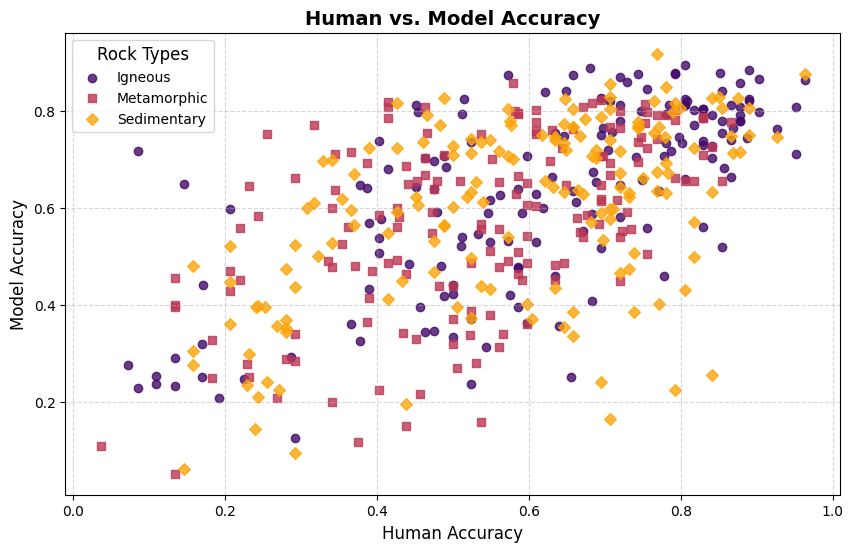

In [181]:
stat, p_value = pearsonr(group_means["Avg_Human_Accuracy"], group_means["Model_Performance"])
print(f"Pearson Correlation Statistic: {stat}")
print(f"Pearson Correlation P-Value: {p_value}")


markers = {1: 'o', 2: 's', 3: 'D'} 
cmap = [plt.cm.inferno(i) for i in [0.2, 0.5, 0.8]]
class_names = ['Igneous', 'Metamorphic', 'Sedimentary']

plt.figure(figsize=(10, 6))

for i, label in enumerate(group_means['Label'].unique()):
    subset = group_means[group_means['Label'] == label]
    plt.scatter(
        subset['Avg_Human_Accuracy'],
        subset['Model_Performance'],
        c=[cmap[i]], 
        marker=markers[label],
        label=f"{class_names[i]}",
        alpha=0.8
    )

# Add labels, title, and legend
plt.xlabel('Human Accuracy', fontsize=12)
plt.ylabel('Model Accuracy', fontsize=12)
plt.title('Human vs. Model Accuracy', fontsize=14, fontweight='bold')
plt.legend(title='Rock Types', title_fontsize=12, fontsize=10, loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()



In [182]:
group_means

,rocknumber,Avg_Human_Accuracy,Model_Performance,Label,Differential
0,1,0.746951,0.798498,1,-0.051547
1,2,0.719512,0.647789,1,0.071724
2,3,0.451220,0.811835,1,-0.360616
3,4,0.500000,0.333419,1,0.166581
4,5,0.512195,0.539184,1,-0.026989
...,...,...,...,...,...
475,476,0.576220,0.769887,3,-0.193667
476,477,0.524390,0.712284,3,-0.187893
477,478,0.426829,0.591665,3,-0.164836
478,479,0.365854,0.596113,3,-0.230259


In [183]:
categories = {"Igneous" : 1, "Metamorphic" : 2, "Sedimentary" : 3}

for cat in categories.keys():
    curr_df = group_means[group_means["Label"] == categories[cat]]
    dist1 = curr_df["Avg_Human_Accuracy"]
    dist2 = curr_df["Model_Performance"]

    correlation_coefficient, p_value = pearsonr(dist1, dist2)
    print("********************* {0} *********************".format(cat))
    print("Correlation Coefficient:", round(correlation_coefficient, 3))
    print("P-value:", p_value)

********************* Igneous *********************
Correlation Coefficient: 0.687
P-value: 1.0264510919421229e-23
********************* Metamorphic *********************
Correlation Coefficient: 0.531
P-value: 4.83899358050871e-13
********************* Sedimentary *********************
Correlation Coefficient: 0.529
P-value: 6.485112081757571e-13


### Answers and Observations

1. Our best model's accuracy is 0.7 and Human's accuracy is around 0.58. The model is performing slightly better than the humans on this data.

2. The mean and standard deviation for each rock has been computed.

3. The plot between human accuracies and model predictions has been plotted with each rock type depicted with a different hue.

4. The overall correlation between the human and model predictions is around 0.6 with a p value much less than 0.05. This meand the correlation is significant.

5. The correlation for each category has also been computed in the above cell. The p-value for each category is less than 0.05.

6. The high correlation for the igneous rock signifies it might be easier to spot for a human eye compared to the 2 other types.